# World Wide Products Inc.

## Introduction


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
df=pd.read_csv("/Users/anissakhan/Dropbox/Nissa_stuff/KU_CS/EECS731/731-Project-5-Khan/Data/RawData/HistoricalProductDemand.csv")
df

,Product_Code,Warehouse,Product_Category,Date,Order_Demand
0,Product_0993,Whse_J,Category_028,2012/7/27,100
1,Product_0979,Whse_J,Category_028,2012/1/19,500
2,Product_0979,Whse_J,Category_028,2012/2/3,500
3,Product_0979,Whse_J,Category_028,2012/2/9,500
4,Product_0979,Whse_J,Category_028,2012/3/2,500
...,...,...,...,...,...
1048570,Product_1791,Whse_J,Category_006,2016/4/27,1000
1048571,Product_1974,Whse_J,Category_006,2016/4/27,1
1048572,Product_1787,Whse_J,Category_006,2016/4/28,2500
1048573,Product_0901,Whse_J,Category_023,2016/10/7,50


In [86]:
df.dtypes

Product_Code        object
Warehouse           object
Product_Category    object
Date                object
Order_Demand        object
dtype: object

In [87]:
new = df["Product_Code"].str.split("_", n = 1, expand = True)
df["Code"]=new[1]

In [88]:
new = df["Product_Category"].str.split("_", n = 1, expand = True)
df["Category"]=new[1]
df.head()

,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Code,Category
0,Product_0993,Whse_J,Category_028,2012/7/27,100,0993,028
1,Product_0979,Whse_J,Category_028,2012/1/19,500,0979,028
2,Product_0979,Whse_J,Category_028,2012/2/3,500,0979,028
3,Product_0979,Whse_J,Category_028,2012/2/9,500,0979,028
4,Product_0979,Whse_J,Category_028,2012/3/2,500,0979,028


In [89]:
df['Code'] = df['Code'].astype('float')
df['Category'] = df['Category'].astype('float')
df['Warehouse'] = df['Warehouse'].astype('string')
df['Date'] = df['Date'].astype('string')
df['Product_Category'] = df['Product_Category'].astype('string')
df['Product_Code'] = df['Product_Code'].astype('string')
df.dtypes

Product_Code         string
Warehouse            string
Product_Category     string
Date                 string
Order_Demand         object
Code                float64
Category            float64
dtype: object

In [90]:
df['Order_Demand'] = df['Order_Demand'].astype('string')

In [91]:
df.Order_Demand = df.Order_Demand.str.strip()

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1048575 non-null  string 
 1   Warehouse         1048575 non-null  string 
 2   Product_Category  1048575 non-null  string 
 3   Date              1037336 non-null  string 
 4   Order_Demand      1048575 non-null  string 
 5   Code              1048575 non-null  float64
 6   Category          1048575 non-null  float64
dtypes: float64(2), string(5)
memory usage: 56.0 MB


In [93]:
df.dropna(subset = ["Date"], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1037336 entries, 0 to 1048574
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Product_Code      1037336 non-null  string 
 1   Warehouse         1037336 non-null  string 
 2   Product_Category  1037336 non-null  string 
 3   Date              1037336 non-null  string 
 4   Order_Demand      1037336 non-null  string 
 5   Code              1037336 non-null  float64
 6   Category          1037336 non-null  float64
dtypes: float64(2), string(5)
memory usage: 63.3 MB


In [94]:
df=df.reset_index()
df.head()

,index,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Code,Category
0,0,Product_0993,Whse_J,Category_028,2012/7/27,100,993.0,28.0
1,1,Product_0979,Whse_J,Category_028,2012/1/19,500,979.0,28.0
2,2,Product_0979,Whse_J,Category_028,2012/2/3,500,979.0,28.0
3,3,Product_0979,Whse_J,Category_028,2012/2/9,500,979.0,28.0
4,4,Product_0979,Whse_J,Category_028,2012/3/2,500,979.0,28.0


In [95]:
count=0
for i in range(0,len(df['Order_Demand'])):
    if("(" in df['Order_Demand'][i]):
        df['Order_Demand'][i] = df['Order_Demand'][i].rstrip(")")
        df['Order_Demand'][i] = df['Order_Demand'][i].lstrip("(")
        df['Order_Demand'][i] = "-" + df['Order_Demand'][i]
        count=count+1
        #df.drop([i], inplace=True, axis=0)
        if(count<3):
            print(df.iloc[i])
            
print('Times Order_Demand variable is negative =', count)

index                     112290
Product_Code        Product_2169
Warehouse                 Whse_A
Product_Category    Category_024
Date                    2012/8/9
Order_Demand                  -1
Code                        2169
Category                      24
Name: 112289, dtype: object
index                     112307
Product_Code        Product_2132
Warehouse                 Whse_A
Product_Category    Category_009
Date                   2012/11/1
Order_Demand                 -24
Code                        2132
Category                       9
Name: 112306, dtype: object
Times Order_Demand variable contains non-numeric values = 5899


In [96]:
df['Order_Demand'] = df['Order_Demand'].astype('float')

In [97]:
df.dtypes

index                 int64
Product_Code         string
Warehouse            string
Product_Category     string
Date                 string
Order_Demand        float64
Code                float64
Category            float64
dtype: object

In [119]:
dfProd=df.query("Product_Code == 'Product_0979'")[['index', 'Product_Code', 'Warehouse', 'Product_Category', 'Date', 'Order_Demand', 'Code', 'Category']]
dfProd.head()

,index,Product_Code,Warehouse,Product_Category,Date,Order_Demand,Code,Category
1,1,Product_0979,Whse_J,Category_028,2012/1/19,500.0,979.0,28.0
2,2,Product_0979,Whse_J,Category_028,2012/2/3,500.0,979.0,28.0
3,3,Product_0979,Whse_J,Category_028,2012/2/9,500.0,979.0,28.0
4,4,Product_0979,Whse_J,Category_028,2012/3/2,500.0,979.0,28.0
5,5,Product_0979,Whse_J,Category_028,2012/4/19,500.0,979.0,28.0


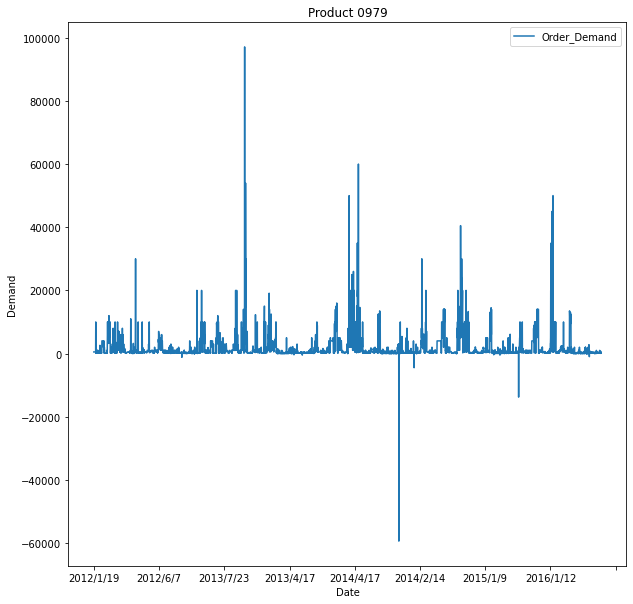

In [118]:
ax = plt.gca()
#plt.plot(figsize=(20,20))

dfProd.plot(kind='line',x='Date',y='Order_Demand', figsize=(10,10), ax=ax)

plt.title('Product 0979')
plt.xlabel('Date')
plt.ylabel('Demand')

plt.show()